In [ ]:
from torch.utils.data import random_split

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import math
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
from tqdm import tqdm_notebook
from sklearn.cluster import DBSCAN
from tqdm import notebook
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transform
from torchvision.io import read_image
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/기말과제111/archive.zip

In [ ]:
import pandas as pd

In [ ]:
data_read = pd.read_csv('/content/train.csv')
train_ID = data_read['ImageId'].tolist()
mask_ID = data_read['MaskId'].tolist()

In [ ]:
class Potdataset(Dataset):
    def __init__(self, data_dir, masked_dir, transform = True, IMAGE_SIZE = 224, phase = 'train'):
        
        self.data_dir = data_dir
        self.masked_dir = masked_dir
        if phase == 'train':
          self.data_names = train_ID[:13000]
          self.masked_names = mask_ID[:13000]
        else:
          self.data_names = train_ID[13000:]
          self.masked_names = mask_ID[13000:]

        
        self.dataset_size = len(self.data_names)
        self.IMAGE_SIZE = IMAGE_SIZE
        self.transform = transform
        assert len(self.data_names) ==len(self.masked_names)
        
        
    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.data_dir+ '/images/' + self.data_names[idx]))
        image = cv2.resize(image, dsize = (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)

        mask = cv2.imread(os.path.join(self.masked_dir+ '/masks/' + self.masked_names[idx]))
        mask = cv2.resize(mask, dsize = (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255

        mask_H, mask_W, mask_C = mask.shape
        background= np.ones(shape = (mask_H, mask_W))
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 0] = 0
        background[mask[..., 2] != 0] = 0
        mask = np.concatenate([np.expand_dims(background, axis = -1), mask], axis= -1)
        mask= np.argmax(mask, axis = -1)
      
        if self.transform:
          image = self.transform(image)
        target = torch.from_numpy(mask).long()
        return image, target


In [ ]:
transform_image = transform.Compose([transform.ToTensor(),
                                      transform.Normalize([0.485, 0.485, 0.485], [0.229, 0.229, 0.229])])

In [ ]:
data_dir = '/content/images'
label_dir = '/content/masks'

train_set = Potdataset(data_dir, label_dir, transform = transform_image, phase = 'train')
validation_set = Potdataset(data_dir, label_dir, transform = transform_image, phase = 'validation')

In [ ]:
image, target = train_set[12999]

In [ ]:
print(f'이미지의 크기: {image.shape}, 라벨의 크기: {target.shape}')

이미지의 크기: torch.Size([3, 224, 224]), 라벨의 크기: torch.Size([224, 224])


이미지는 [채널수, 행 크기, 열 크기]로 구성, 라벨은 [행의 크기, 열의 크기]
로 구성되어 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


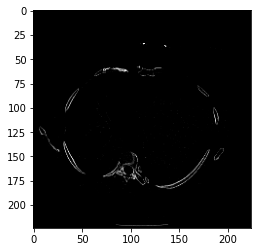

In [ ]:
plt.imshow(image.permute(1, 2, 0))

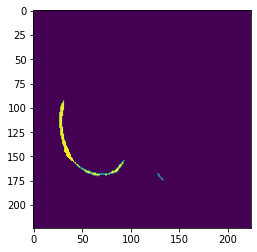

In [ ]:
plt.imshow(target)

#배치형태로 이미지가 구성이 될때 배치를 어떻게 구성할 것이냐? 이미지, 라벨, maskdataset을 어떻게 미니배치 형태로 구성을 할 것인지 collate_function을 통해 dataloader을 통해 전달  

입력사진: [배치사이즈, 채널, 행 크기, 열 크기]  
라벨: [배치사이즈, 행 크기, 열 크기]

In [ ]:
def collate_fn(batch):  
  images = []
  targets = []
  for a, b in batch:
    images.append(a)
    targets.append(b)
  
  images = torch.stack(images, dim = 0)
  targets = torch.stack(targets, dim = 0)
  return images, targets

In [ ]:
def build_dataloader(train_set, validation_set, batch_size = 4):
  dataloaders = {}
  dataloaders['train'] = DataLoader(train_set, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
  dataloaders['validation'] = DataLoader(validation_set, batch_size = batch_size, shuffle = False, collate_fn = collate_fn)
  return dataloaders


In [ ]:
dataloaders = build_dataloader(train_set, validation_set, batch_size = 16)

dataloader을 훈련과 검증에 따른 수행을 다르게 하기 위해, key와 value를 가진 딕셔너리로 정의하였다. 

#모델 정의하기

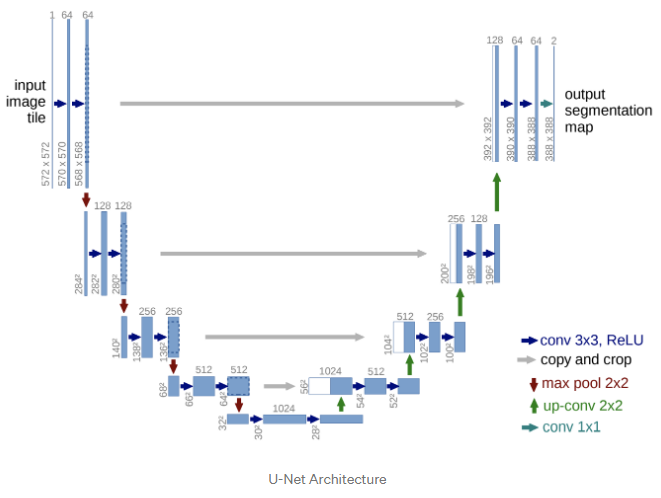

Encoder-Decoder구조로 이루어진 Unet을 구현하려고 한다.  
- Encoder: Encoder로 이미지에서 유의미한 feature map을 형성합니다.
- Decoder: 입력이미지에 해당하는 semantic한 정보를 upsampling하면서 segmentation결과를 만듭니다. 


up conv: 원본이미지에서 기본 컨볼루션(곱 연산 누적 합)하면 컨볼루션을 한 결과값과 컨볼루션 필터 값을 가지고 역행렬을 구합니다. 

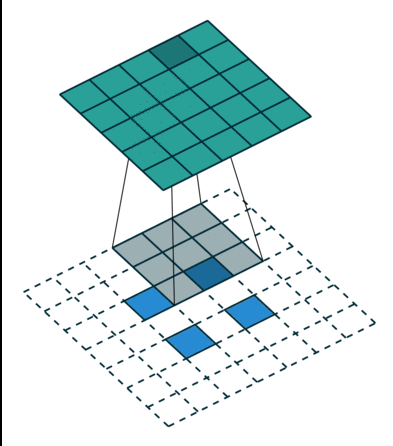

skip connection: encoder에서 layer을 통과하면서 객체 정보는 많아지지만,     
resolution은 줄어듭니다. 이 상태로 up convolution을 하면, 원본 이미지 자세한   부분을 놓지게 됩니다.  
 모서리와 target과 차이를 최소화하기 위해 사용됩니다.

#기본 모듈 정의

In [ ]:
def Convlayer(in_channels, out_channels):
  layers = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True),

      nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
  )
  return layers

In [ ]:
class spatial_attention(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.spatial = nn.Conv2d(in_channels, 1, kernel_size = 3, padding = 1)

  def forward(self, input):
    x = torch.sigmoid(self.spatial(input))
    return torch.mul(x, input)#마지막에 출력값과 입력값을 element-wise 곱을 하였다.

In [ ]:
class channel_attention(nn.Module):
  def __init__(self, in_channels, r = 16):
    super().__init__()
    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, r),
        nn.ReLU(),
        nn.Linear(r, in_channels),
        nn.Sigmoid()
        )
    
  def forward(self, input):
    x = self.avg(input) #x.size([batch_size, channel_size, 1, 1])
    x = x.view(x.size(0), -1) #x.size([batch_size, channel_size])
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1, 1)
    return torch.mul(x, input)

In [ ]:
def attention_block(mode = "Spatial", input_dim = None, r = None):
    if mode == "Spatial":
        return spatial_attention(input_dim)
    elif mode == "Channel":
        return channel_attention(input_dim, r)
    
    else:
        return nn.Sequential()

#기본 Unet (학습안됨)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 64)
    self.conv_block2 = Convlayer(in_channels = 64, out_channels = 128)
    self.conv_block3 = Convlayer(in_channels = 128, out_channels = 256)
    self.conv_block4 = Convlayer(in_channels = 256, out_channels = 512)
    self.conv_block5 = Convlayer(in_channels = 512, out_channels = 1024)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    
  

    out = self.conv_block5(out)

    return out, encode_features

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 512, out_channels = 256)
    self.conv_block1 =  Convlayer(in_channels = 512, out_channels = 256)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block2 =  Convlayer(in_channels = 256, out_channels = 128)

    self.upconv_layer3 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block3 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer4 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block4 =  Convlayer(in_channels = 64, out_channels = 32)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    
    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)

  

    return out

In [ ]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(64, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [ ]:
NUM_CLASSES = 4
model = Unet(NUM_CLASSES)

#평가지표 정의하기

Dice similarity coefficient

Dice: (2 x (A*B) / (A + B))

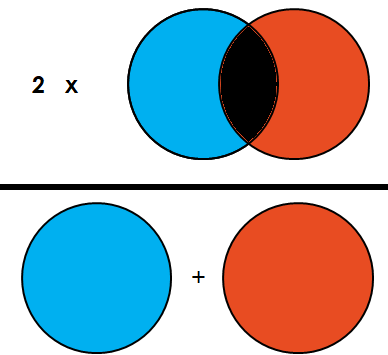

Segmentation에서 F1 score과 비슷하다.   
F1 score이란 precision(정확도)과 recall(재현율)을 고려한  
성능지표이다.

1-dsc를 하면? dsc loss가 나온다.

In [ ]:
class Unet_metric():
  def __init__(self, num_classes):
    self.num_classes = num_classes
    self.CE_loss = nn.CrossEntropyLoss(reduction = "mean") #detection, segmentation은 여러개의 element가 존재
    #2, 3차원이라서 mean을 사용

  def __call__(self, pred, target):
    onehot_pred = F.one_hot(torch.argmax(pred, dim = 1), num_classes = self.num_classes).permute(0, 3, 1, 2)
    onehot_target = F.one_hot(target, num_classes = self.num_classes).permute(0, 3, 1, 2)
    dice_coefficient = self.get_batch_dice_coefficient(onehot_pred, onehot_target)
    loss1 = self.get_dice_loss(onehot_pred, onehot_target)
    loss2 = self.CE_loss(pred, target)
    loss = loss1 + loss2
    return loss, dice_coefficient
  

  def get_dice_coefficient(self,  pred, target):
    dice = 0
    for class_idx in range(1, self.num_classes):
      A = pred[class_idx]
      B = target[class_idx]
      set_inter = torch.dot(A.reshape(-1).float(), B.reshape(-1).float())
      set_sum = A.sum() + B.sum()
      if set_sum.item()== 0:
        set_sum = 2 * set_inter
      dice += ((2 * set_inter) / (set_sum + 1e-8))
    dice /= (self.num_classes - 1)
    return dice

  def get_batch_dice_coefficient(self, pred, target):
    num_batch = pred.shape[0]
    dice = 0
    for batch_idx in range(num_batch):
      dice += self.get_dice_coefficient(pred[batch_idx], target[batch_idx])
    return dice / num_batch

  def get_dice_loss(self, pred, target):
    return 1. - self.get_batch_dice_coefficient(pred, target)


In [ ]:
criterion = Unet_metric(num_classes = NUM_CLASSES)

In [ ]:
for i, data in enumerate(dataloaders['train']):
  images, labels = data
  predictions = model(images)
  loss, asc = criterion(predictions, labels)
  print(loss, asc)



  if i== 0:
    break

tensor(2.2269, grad_fn=<AddBackward0>) tensor(0.0513)


Loss function 구현, SGDM최적화사용

2개의 loss사용   
dice loss와 cross entropy loss를 사용

#학습과정

In [ ]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
  losses = {}
  dice_coefficients = {}
  
  for phase in ["train", "validation"]:
    running_loss = 0.0
    running_dice_coeff = 0.0

    if phase == "train":
      model.train()

    else:
      model.eval()

    for idx, data in enumerate(dataloaders[phase]):
      images = data[0].to(DEVICE)
      labels = data[1].to(DEVICE)
      with torch.set_grad_enabled(phase == "train"):
        predictions = model(images)
        loss, dice_coefficient = criterion(predictions, labels)

        if phase == "train":
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        running_loss += loss.item()
        running_dice_coeff += dice_coefficient.item()

        if phase == "train":
          if idx > 0 and idx % 100 == 0:
            text = f"{idx}/{len(dataloaders['train'])}" +\
            f"-Running loss: {loss.item():.4f}" + \
            f"-Running dice: {dice_coefficient.item():4f}"
            print(text)

    losses[phase] = running_loss / len(dataloaders[phase])
    dice_coefficients[phase] = running_dice_coeff / len(dataloaders[phase])
  return losses, dice_coefficients

        

    

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f1d46f338d0>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7f1d46f33a50>}

#모델1 정의

In [ ]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 32)
    self.conv_block2 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block3 = Convlayer(in_channels = 64, out_channels = 128)
    self.conv_block4 = Convlayer(in_channels = 128, out_channels = 256)
    self.conv_block5 = Convlayer(in_channels = 256, out_channels = 512)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    
  

    out = self.conv_block5(out)

    return out, encode_features

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 512, out_channels = 256)
    self.conv_block1 =  Convlayer(in_channels = 512, out_channels = 256)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block2 =  Convlayer(in_channels = 256, out_channels = 128)

    self.upconv_layer3 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block3 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer4 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block4 =  Convlayer(in_channels = 64, out_channels = 32)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    
    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)

  

    return out

In [ ]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(32, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [ ]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

cuda


In [ ]:
num_epochs = 30
best_epoch = 0
best_score = 0.0

for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{11 + epoch} / {15} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{11 + epoch} / {15} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")


In [ ]:
epoch = np.arange(30)
import csv
def save_result(epoch_, train_loss_, train_accuracy_, val_loss_, val_accuracy_, file_name):
  epoch_ = np.array(['epoch'] + list(epoch_))
  train_loss_ = np.array(['train_loss'] + list(train_loss_)) 
  train_accuracy_ = np.array(['train_accuracy'] + list(train_accuracy_))
  val_loss_ = np.array(['val_loss'] + list(val_loss_))
  val_accuracy_ = np.array(['val_accuracy']+ list(val_accuracy_))
  with open(file_name, 'w') as file:     #"model0.csv"
    writer = csv.writer(file)
    for i in range(len(epoch_)): 
      writer.writerow([epoch_[i], train_loss_[i],train_accuracy_[i],
                   val_loss_[i], val_accuracy_[i]])

In [ ]:
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model1.csv")

#모델2 정의

In [ ]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 16)
    self.conv_block2 = Convlayer(in_channels = 16, out_channels = 32)
    self.conv_block3 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block4 = Convlayer(in_channels = 64, out_channels = 128)
    self.conv_block5 = Convlayer(in_channels = 128, out_channels = 256)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    
  

    out = self.conv_block5(out)

    return out, encode_features


In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block1 =  Convlayer(in_channels = 256, out_channels = 128)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block2 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer3 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block3 =  Convlayer(in_channels = 64, out_channels = 32)

    self.upconv_layer4 = UpConvLayer(in_channels = 32, out_channels = 16)
    self.conv_block4 =  Convlayer(in_channels = 32, out_channels = 16)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)
    

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)
    

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    

    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)
  

    return out

In [ ]:
def UpConvLayer(in_channels, out_channels):
  layers = nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace = True)
  )
  return layers

In [ ]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(16, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [ ]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
num_epochs = 30
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coeff = [], []
val_loss, val_dice_coeff = [], []
for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{epoch} / {num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{epoch} / {num_epochs} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

In [ ]:
#2시간 17분
epoch = np.arange(30)
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model2.csv")

#모델3: Spatial Attention 정의

In [ ]:
def attention_block(mode = 'None', input_dim = None , r = None):
  if mode == 'spatial':
    return spatial_attention(input_dim)

  elif mode == 'channel':
    return channel_attention(input_dim, r)
  
  else:
    return nn.Sequential()

In [ ]:
class spatial_attention(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.spatial = nn.Conv2d(in_channels, 1, kernel_size = 3, padding = 1)

  def forward(self, input):
    x = torch.sigmoid(self.spatial(input))
    return torch.mul(x, input)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 16)
    self.conv_block2 = Convlayer(in_channels = 16, out_channels = 32)
    self.conv_block3 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block4 = Convlayer(in_channels = 64, out_channels = 128)
    self.attn1 = attention_block(mode = "Spatial", input_dim = 128, r = 64)
    self.conv_block5 = Convlayer(in_channels = 128, out_channels = 256)
    self.attn2 = attention_block(mode = "Spatial", input_dim = 256, r = 128)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    out = self.attn1(out)
    
  

    out = self.conv_block5(out)
    out = self.attn2(out)

    return out, encode_features

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block1 =  Convlayer(in_channels = 256, out_channels = 128)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block2 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer3 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block3 =  Convlayer(in_channels = 64, out_channels = 32)

    self.upconv_layer4 = UpConvLayer(in_channels = 32, out_channels = 16)
    self.conv_block4 =  Convlayer(in_channels = 32, out_channels = 16)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)
    

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)
    

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    

    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)
  

    return out

In [ ]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(16, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [ ]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

cuda


In [ ]:
num_epochs = 30
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coeff = [], []
val_loss, val_dice_coeff = [], []
for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{epoch} / {num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{epoch} / {num_epochs} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

In [ ]:
#2시간 19분
epoch = np.arange(30)
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model3.csv")

#모델4 Channel Attention 정의

In [ ]:
def attention_block(mode = 'None', input_dim = None , r = None):
  if mode == 'spatial':
    return spatial_attention(input_dim)

  elif mode == 'channel':
    return channel_attention(input_dim, r)
  
  else:
    return nn.Sequential()

In [ ]:
class channel_attention(nn.Module):
  def __init__(self, in_channels, r = 16):
    super().__init__()
    self.avg = nn.AdaptiveAvgPool2d((1,1))
    self.excitation = nn.Sequential(
        nn.Linear(in_channels, r),
        nn.ReLU(),
        nn.Linear(r, in_channels),
        nn.Sigmoid()
        )
    
  def forward(self, input):
    x = self.avg(input) #x.size([batch_size, channel_size, 1, 1])
    x = x.view(x.size(0), -1) #x.size([batch_size, channel_size])
    x = self.excitation(x)
    x = x.view(x.size(0), x.size(1), 1, 1)
    return torch.mul(x, input)

In [ ]:
class Encoder(nn.Module):
  def __init__(self,):
    super().__init__()
    self.conv_block1 = Convlayer(in_channels = 3, out_channels = 16)
    self.conv_block2 = Convlayer(in_channels = 16, out_channels = 32)
    self.conv_block3 = Convlayer(in_channels = 32, out_channels = 64)
    self.conv_block4 = Convlayer(in_channels = 64, out_channels = 128)
    self.attn1 = attention_block(mode = "Channel", input_dim = 128, r = 64)
    self.conv_block5 = Convlayer(in_channels = 128, out_channels = 256)
    self.attn2 = attention_block(mode = "Channel", input_dim = 256, r = 128)
    self.pool = nn.MaxPool2d(kernel_size = 2)

  def forward(self, x):
    encode_features = []

    out = self.conv_block1(x)
    encode_features.append(out)
    out = self.pool(out)
  
    
    out = self.conv_block2(out)
    encode_features.append(out)
    out = self.pool(out)
    

    out = self.conv_block3(out)
    encode_features.append(out)
    out = self.pool(out)
    
    

    out = self.conv_block4(out)
    encode_features.append(out)
    out = self.pool(out)
    out = self.attn1(out)
    
  

    out = self.conv_block5(out)
    out = self.attn2(out)

    return out, encode_features

In [ ]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.upconv_layer1 = UpConvLayer(in_channels = 256, out_channels = 128)
    self.conv_block1 =  Convlayer(in_channels = 256, out_channels = 128)
    
    self.upconv_layer2 = UpConvLayer(in_channels = 128, out_channels = 64)
    self.conv_block2 =  Convlayer(in_channels = 128, out_channels = 64)

    self.upconv_layer3 = UpConvLayer(in_channels = 64, out_channels = 32)
    self.conv_block3 =  Convlayer(in_channels = 64, out_channels = 32)

    self.upconv_layer4 = UpConvLayer(in_channels = 32, out_channels = 16)
    self.conv_block4 =  Convlayer(in_channels = 32, out_channels = 16)
    

  def forward(self, x, encoder_features):
    out = self.upconv_layer1(x)
    out = torch.cat([out, encoder_features[-1]], dim = 1)
    out = self.conv_block1(out)
    

    out = self.upconv_layer2(out)
    out = torch.cat([out, encoder_features[-2]], dim = 1)
    out = self.conv_block2(out)
    

    out = self.upconv_layer3(out)
    out = torch.cat([out, encoder_features[-3]], dim = 1)
    out = self.conv_block3(out)
    

    out = self.upconv_layer4(out)
    out = torch.cat([out, encoder_features[-4]], dim = 1)
    out = self.conv_block4(out)
  

    return out

In [ ]:
class Unet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.head= nn.Conv2d(16, num_classes, kernel_size = 1, padding = 0)
  
  def forward(self, x):
    out, encode_features = self.encoder(x)
    out = self.decoder(out, encode_features)
    out = self.head(out)
    return out

In [ ]:
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE= 16
is_cuda = True
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')
print(DEVICE)
model = Unet(num_classes = NUM_CLASSES)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes = NUM_CLASSES)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
num_epochs = 30
best_epoch = 0
best_score = 0.0
train_loss, train_dice_coeff = [], []
val_loss, val_dice_coeff = [], []
for epoch in range(num_epochs):
  losses, dice_coefficients = train_one_epoch(dataloaders, model, criterion, optimizer, DEVICE)
  train_loss.append(losses["train"])
  val_loss.append(losses["validation"])
  train_dice_coeff.append(dice_coefficients["train"])
  val_dice_coeff.append(dice_coefficients["validation"])

  print(f"{epoch} / {num_epochs} - Train loss: {losses['train']:.4f}, Val loss: {losses['validation']:.4f}")
  print(f"{epoch} / {num_epochs} - Train{dice_coefficients['train']:.4f}, Val: {dice_coefficients['validation']:.4f}")

In [ ]:
#2시간 32분
epoch = np.arange(30)
save_result(epoch, train_loss, train_dice_coeff, val_loss, val_dice_coeff, "Model4.csv")

#결과확인

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def plot_result(_df):
  plt.figure(figsize = (13, 13))
  fig1 = plt.subplot(3, 2, 1)
  fig1.plot(_df['epoch'], _df['train_loss'])
  fig1.grid()
  fig1.set_title('Train Loss')

  fig2 = plt.subplot(3, 2, 2)
  fig2.plot(_df['epoch'], _df['train_accuracy'])
  fig2.grid()
  fig2.set_title('Train Accuracy')

  fig3 = plt.subplot(3, 2, 3)
  fig3.plot(_df['epoch'], _df['val_loss'], color = 'orange')
  fig3.grid()
  fig3.set_title('Validation Loss')

  fig4 = plt.subplot(3, 2, 4)
  fig4.plot(_df['epoch'], _df['val_accuracy'], color = 'orange')
  fig4.grid()
  fig4.set_title('Validation Accuracy')

  fig5 = plt.subplot(3, 2, 5)
  fig5.plot(_df['epoch'], _df['train_loss'], label = 'Train Loss')
  fig5.plot(_df['epoch'], _df['val_loss'], color = 'orange', label = 'Vaidation Loss')
  fig5.grid()
  fig5.set_title('Train & Validation Loss')
  fig5.legend(loc ='upper right')

  fig6 = plt.subplot(3, 2, 6)
  fig6.legend(loc ='upper right')
  fig6.plot(_df['epoch'], _df['train_accuracy'], label = 'Train Accuracy')
  fig6.plot(_df['epoch'], _df['val_accuracy'], color = 'orange', label = 'Vaidation Accuracy')
  fig6.grid()
  fig6.set_title('Train & Validation Accuracy')
  fig6.legend(loc ='lower right')

In [ ]:
model1_df = pd.read_csv('/content/Model1.csv')
model2_df = pd.read_csv('/content/Model2.csv')
model3_df = pd.read_csv('/content/Model3.csv')
model4_df = pd.read_csv('/content/Model4.csv')

No handles with labels found to put in legend.


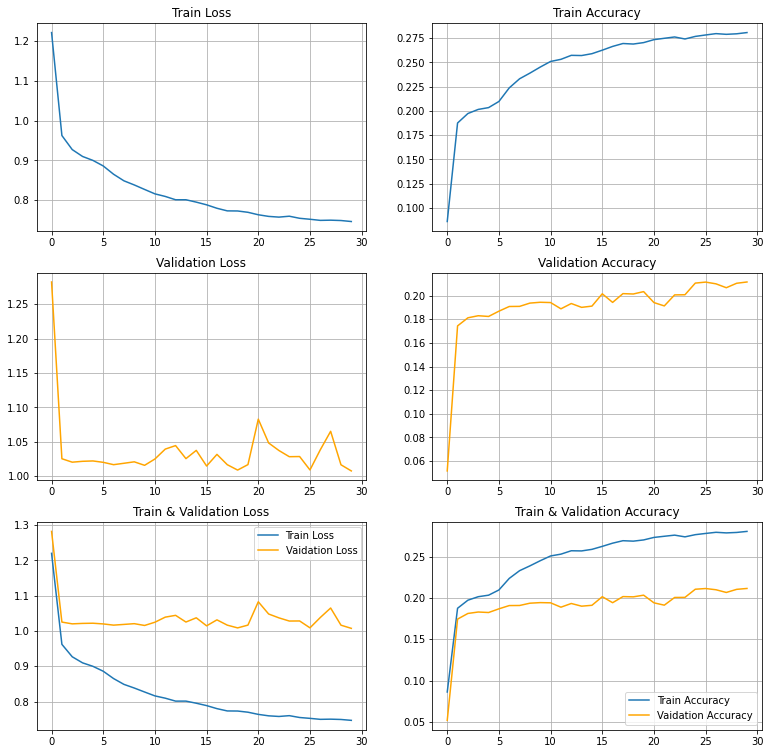

In [ ]:
plot_result(model1_df)

No handles with labels found to put in legend.


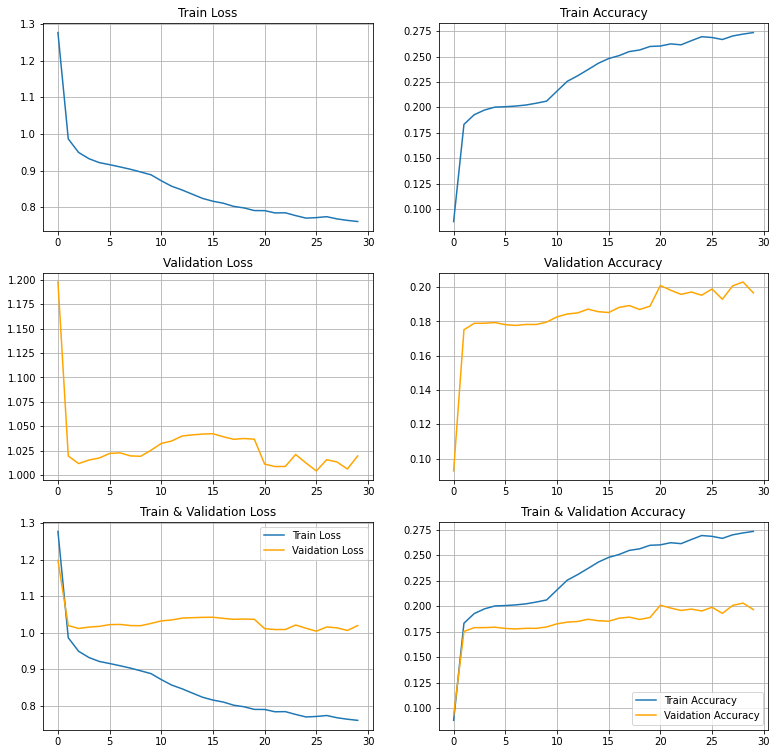

In [ ]:
plot_result(model2_df)

No handles with labels found to put in legend.


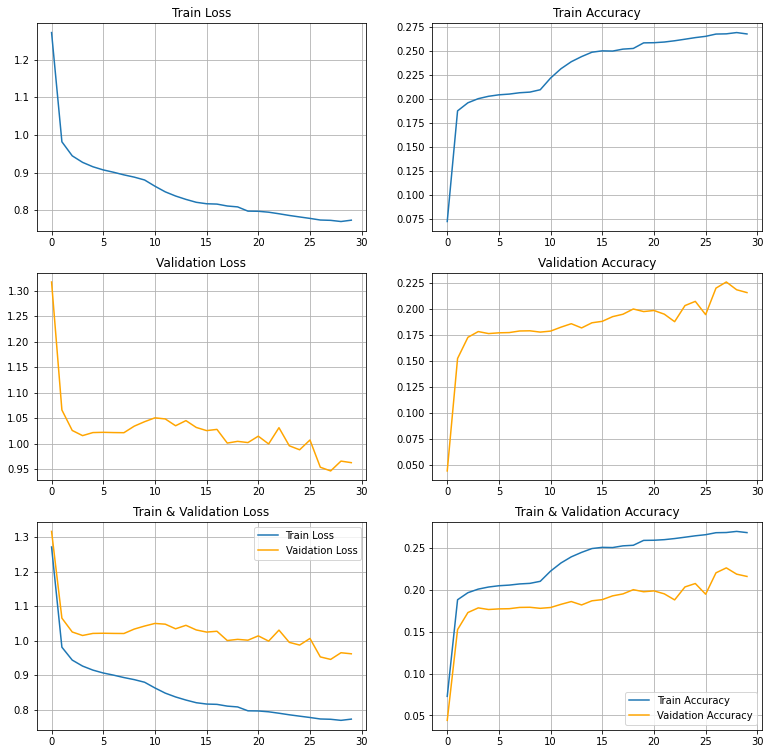

In [ ]:
plot_result(model3_df)

No handles with labels found to put in legend.


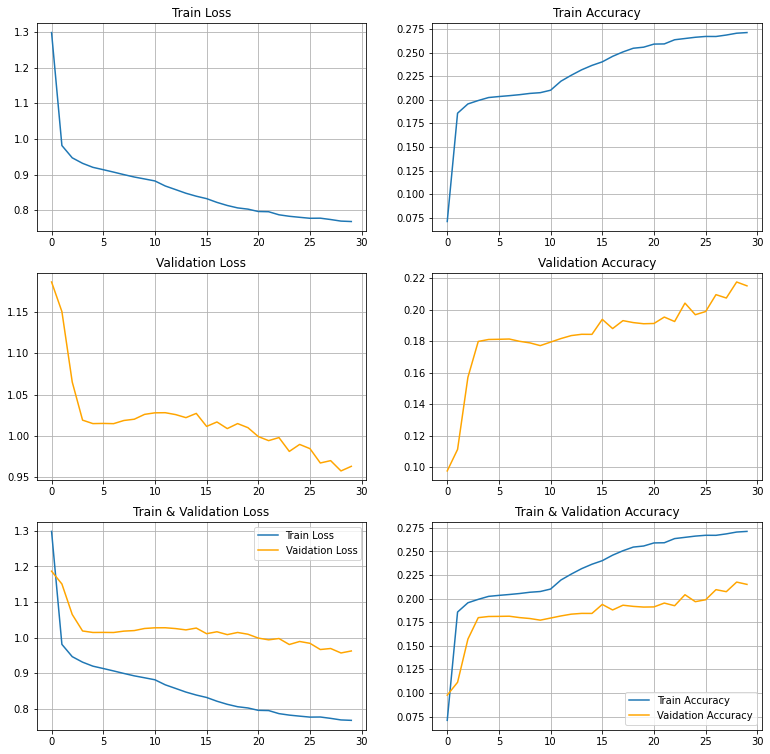

In [ ]:
plot_result(model4_df)

Text(0.5, 1.0, 'train_loss')

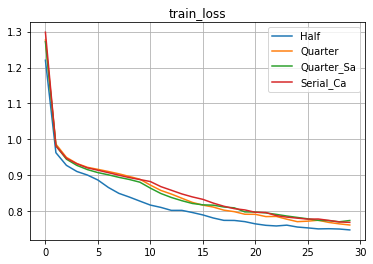

In [ ]:

plt.plot(model1_df['epoch'],model1_df['train_loss'], label = 'Half')
plt.plot(model2_df['epoch'],model2_df['train_loss'], label = 'Quarter')
plt.plot(model3_df['epoch'],model3_df['train_loss'], label = 'Quarter_Sa')
plt.plot(model4_df['epoch'],model4_df['train_loss'], label = 'Serial_Ca')
plt.legend(loc = 'upper right')
plt.grid()
plt.title('train_loss')

Text(0.5, 1.0, 'train_dice_coefficient')

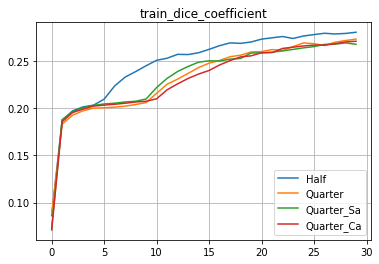

In [ ]:

plt.plot(model1_df['epoch'],model1_df['train_accuracy'], label = 'Half')
plt.plot(model2_df['epoch'],model2_df['train_accuracy'], label = 'Quarter')
plt.plot(model3_df['epoch'],model3_df['train_accuracy'], label = 'Quarter_Sa')
plt.plot(model4_df['epoch'],model4_df['train_accuracy'], label = 'Quarter_Ca')
plt.legend(loc = 'lower right')
plt.grid()
plt.title('train_dice_coefficient')

Text(0.5, 1.0, 'validation_loss')

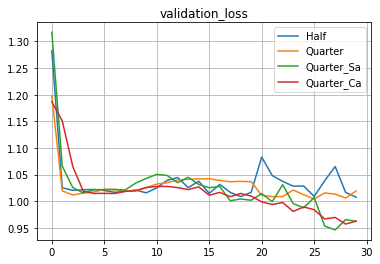

In [ ]:
plt.plot(model1_df['epoch'],model1_df['val_loss'], label = 'Half')
plt.plot(model2_df['epoch'],model2_df['val_loss'], label = 'Quarter')
plt.plot(model3_df['epoch'],model3_df['val_loss'], label = 'Quarter_Sa')
plt.plot(model4_df['epoch'],model4_df['val_loss'], label = 'Quarter_Ca')
plt.legend(loc = 'upper right')
plt.grid()
plt.title('validation_loss')

Text(0.5, 1.0, 'validation_dice_coefficient')

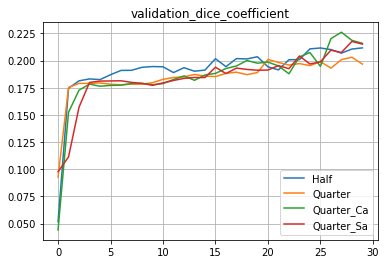

In [ ]:
plt.plot(model1_df['epoch'],model1_df['val_accuracy'], label = 'Half')
plt.plot(model2_df['epoch'],model2_df['val_accuracy'], label = 'Quarter')
plt.plot(model3_df['epoch'],model3_df['val_accuracy'], label = 'Quarter_Ca')
plt.plot(model4_df['epoch'],model4_df['val_accuracy'], label = 'Quarter_Sa')
plt.legend(loc = 'lower right')
plt.grid()
plt.title('validation_dice_coefficient')

In [ ]:
train_loss_min = [min(model1_df['train_loss']), min(model2_df['train_loss']), min(model3_df['train_loss']), min(model4_df['train_loss'])]
for i in range(len(train_loss_min)):
  print(train_loss_min[i])

0.7471477443588322
0.7609052460498622
0.769813802739351
0.7681632057327186


In [ ]:
train_loss_min_idx = train_loss_min.index(min(train_loss_min))
print(f"model{1+train_loss_min_idx}가 가장 낮은 훈련 loss를 가짐")

model1가 가장 낮은 훈련 loss를 가짐


In [ ]:
train_accuracy_max = [max(model1_df['train_accuracy']), max(model2_df['train_accuracy']), max(model3_df['train_accuracy']), max(model4_df['train_accuracy'])]

In [ ]:
train_accuracy_max_idx = train_accuracy_max.index(max(train_accuracy_max))
print(f"model{1+train_accuracy_max_idx}가 가장 높은 훈련 정확도를 가짐")

model1가 가장 높은 훈련 정확도를 가짐


In [ ]:
val_loss_min = [min(model1_df['val_loss']), min(model2_df['val_loss']), min(model3_df['val_loss']), min(model4_df['val_loss'])]

In [ ]:
val_loss_min_idx = val_loss_min.index(min(val_loss_min))
print(f"model{val_loss_min_idx+1}가 가장 낮은 검증 loss를 가짐")

model3가 가장 낮은 검증 loss를 가짐


In [ ]:
val_accuracy_max = [max(model1_df['val_accuracy']), max(model2_df['val_accuracy']), max(model3_df['val_accuracy']), max(model4_df['val_accuracy'])]
for i in range(len(val_accuracy_max)):
  print(val_accuracy_max[i])

0.2116175879754619
0.2030231785556052
0.2259952710210827
0.2175402834245922


In [ ]:
val_accuracy_max_idx = val_accuracy_max.index(max(val_accuracy_max))
print(f"model{val_accuracy_max_idx+1}이 가장 높은 검증 정확도를 가짐")

model3이 가장 높은 검증 정확도를 가짐
